# Simulation config

In [1]:
import yaml

with open('../data/run_summary.yaml') as f:
    run_summary = yaml.load(f)
    
run_summary

/home/christiaanjs/miniconda3/envs/libsbn/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


{'config': {'beast_jar': 'lib/feast.jar',
  'burn_in': 0.1,
  'chain_length': 1000000,
  'estimate_clock_rate': False,
  'estimate_topology': False,
  'frequencies': [0.24, 0.26, 0.26, 0.24],
  'inference': 'mean_field',
  'init_values': {'clock_rate': 1.0, 'kappa': 2.0, 'pop_size': 10},
  'kappa': 2.0,
  'log_every': 100,
  'lsd_executable': 'lsd',
  'mutation_rate': 0.01,
  'n_eval_samples': 200,
  'n_iter': 40000,
  'n_runs': 10,
  'n_taxa': 5,
  'n_trace_samples': 1000,
  'nuts_draws': 10000,
  'nuts_tune': 100,
  'out_dir': 'out/0',
  'prior_params': {'clock_rate': {'m': 1.0, 's': 1.25},
   'kappa': {'m': 1.0, 's': 1.25},
   'pop_size': {'m': 2.0, 's': 0.1}},
  'rate_sd': None,
  'relaxed_clock': False,
  'sampling_window': 0,
  'seed': 1,
  'sequence_length': 1000},
 'date_trait_string': 'A=0.0,B=0.0,C=0.0,D=0.0,E=0.0',
 'newick_string': '((B:0.910978734132923,E:0.910978734132923):10.536638972692,((D:1.9219086332202198,C:1.9219086332202198):2.438807589499588,A:4.360716222719808):

# Model

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import treeflow.coalescent
tfd = tfp.distributions

pop_size = tf.convert_to_tensor(run_summary['pop_size'])
taxon_count = run_summary['config']['n_taxa']
sampling_times = tf.zeros(taxon_count)
prior = tfd.JointDistributionNamed(dict(
    tree=treeflow.coalescent.ConstantCoalescent(taxon_count=taxon_count, pop_size=pop_size, sampling_times=sampling_times)
))


In [3]:
import treeflow.substitution_model
import treeflow.sequences
import treeflow.tree_processing

from importlib import reload
reload(treeflow.sequences)

fasta_file = '../data/sim-seq.fasta'
newick_file = '../data/sim-seq.newick'
subst_model = treeflow.substitution_model.HKY()
category_weights = tf.ones(1)
category_rates = tf.ones(1)
mutation_rate = tf.convert_to_tensor(run_summary['config']['mutation_rate'], dtype=tf.float32)
kappa = tf.convert_to_tensor(run_summary['config']['kappa'], dtype=tf.float32)
frequencies = tf.convert_to_tensor(run_summary['config']['frequencies'], dtype=tf.float32)
tree, taxon_names = treeflow.tree_processing.parse_newick(newick_file)
tree_ = treeflow.tree_processing.tree_to_tensor(tree)
alignment = treeflow.sequences.get_encoded_sequences(fasta_file, taxon_names)
log_prob_conditioned = treeflow.sequences.log_prob_conditioned_branch_only(
    alignment,
    tree['topology'],
    1,
    subst_model,
    category_weights,
    category_rates,
    frequencies,
    kappa=kappa
)
log_prob = lambda **z: (prior.log_prob(z) + log_prob_conditioned(branch_lengths=treeflow.sequences.get_branch_lengths(z['tree']) * mutation_rate))
log_prob(tree=tree_)

<tf.Tensor: shape=(), dtype=float32, numpy=-2639.814>

# Approximation

In [4]:
import treeflow.tree_transform

topology = treeflow.tree_processing.update_topology_dict(tree['topology'])
anchor_heights = treeflow.tree_processing.get_node_anchor_heights(tree['heights'], topology['postorder_node_indices'], topology['child_indices'])
anchor_heights = tf.convert_to_tensor(anchor_heights, dtype=tf.float32)
tree_chain = treeflow.tree_transform.TreeChain(
    topology['parent_indices'][taxon_count:] - taxon_count,
    topology['preorder_node_indices'][1:] - taxon_count,
    anchor_heights=anchor_heights)
init_heights = tf.convert_to_tensor(tree['heights'][taxon_count:], dtype=tf.float32)
init_heights_trans = tree_chain.inverse(init_heights)
leaf_heights = tf.convert_to_tensor(tree['heights'][:taxon_count], dtype=tf.float32)

height_dist = tfd.Blockwise([
    tfd.Independent(tfd.Deterministic(leaf_heights), reinterpreted_batch_ndims=1),
    tfd.TransformedDistribution(
        distribution=tfd.Independent(tfd.Normal(
            loc=tf.Variable(init_heights_trans, name='q_tree_loc'),
            scale=tfp.util.DeferredTensor(tf.Variable(tf.ones_like(init_heights_trans), name='q_tree_scale'), tf.nn.softplus)
        ), reinterpreted_batch_ndims=1),
        bijector=tree_chain
    )
])
q = tfd.JointDistributionNamed(dict(
        tree=treeflow.tree_transform.FixedTopologyDistribution(
            height_distribution=height_dist,
            topology=tree['topology']
)))
log_prob(**q.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-2852.398>

# Inference

In [5]:
from tqdm.notebook import tqdm
import treeflow.vi

res = treeflow.vi.fit_surrogate_posterior(log_prob, q, tf.optimizers.Adam(learning_rate=0.01), 10000, iter=lambda x: tqdm(range(x)))

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().



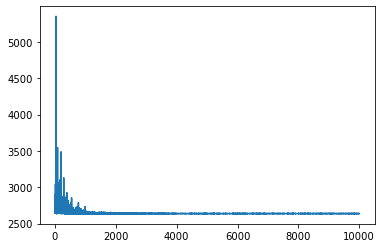

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(res['loss'])

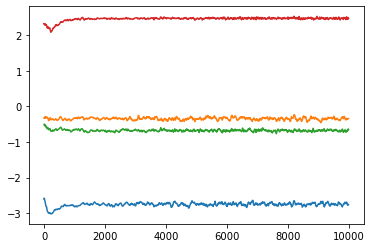

In [7]:
plt.plot(res['vars']['q_tree_loc:0']);

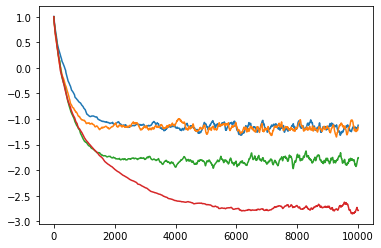

In [8]:
plt.plot(res['vars']['q_tree_scale:0']);

In [9]:
clades = [[] for _ in range(taxon_count - 1)]
for i in topology['postorder_node_indices']:
    for child_index in topology['child_indices'][i]:
        clades[i - taxon_count] += clades[child_index - taxon_count] if child_index >= taxon_count else taxon_names[child_index]

clade_names = [''.join(sorted(names)) for names in clades]
clade_names

['BE', 'CD', 'ACD', 'ABCDE']

In [13]:
import seaborn
import pandas as pd

q_samples = q.sample(10000)
tf_data = pd.DataFrame(q_samples['tree']['heights'][:, taxon_count:].numpy(), columns=clade_names)
tf_data.head()

,BE,CD,ACD,ABCDE
0,0.650861,1.808601,3.577395,11.376193
1,1.186762,1.577706,4.369380,12.938334
2,0.666847,1.872652,3.630246,11.338787
3,0.589825,1.720166,4.316774,11.962845
4,0.581714,1.632247,3.845207,11.238513


In [17]:
import dendropy

def get_node_heights(tree):
    tree.calc_node_ages()
    return { ''.join(sorted([leaf.taxon.label for leaf in node.leaf_iter()])): node.age for node in tree.preorder_node_iter() if not node.is_leaf() }

beast_log = dendropy.TreeList.get(path='beast-log-fixed.trees', schema='nexus')
burn_in = 0.1
beast_log = beast_log[int(len(beast_log) * burn_in):]
beast_samples = [get_node_heights(tree) for tree in tqdm(beast_log)]
beast_data = pd.DataFrame(beast_samples)
beast_data.head()

,ABCDE,BE,ACD,CD
0,11.341205,0.711626,3.550002,1.698692
1,13.124849,0.422325,4.802406,1.861335
2,13.038458,0.667531,4.129650,1.840262
3,12.522115,0.812893,3.945191,1.618585
4,11.688953,0.832430,3.603437,1.644088


Text(0.5, 0.98, 'Tree heights')

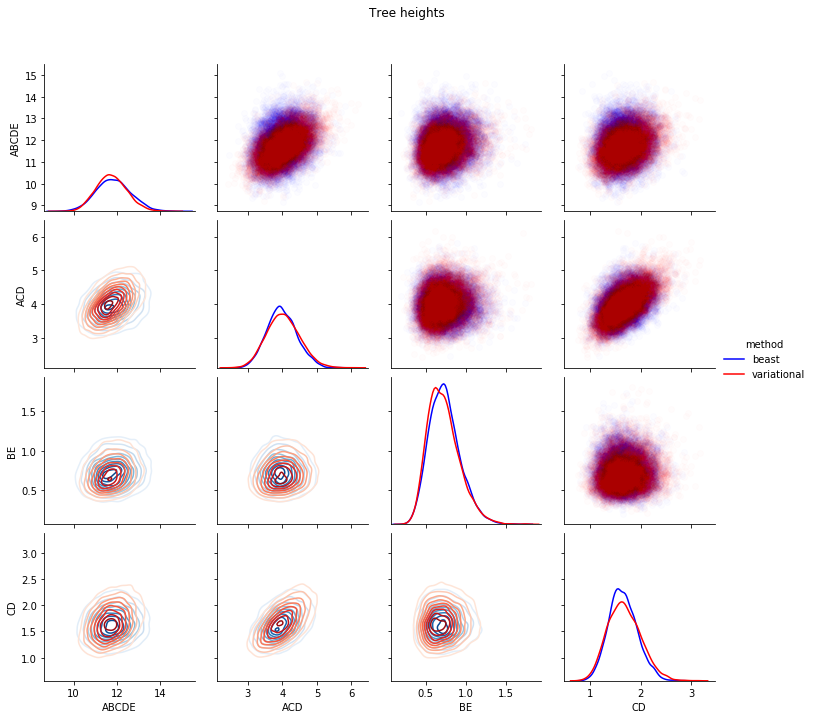

In [45]:
all_data = pd.concat(dict(beast=beast_data, variational=tf_data), sort=True, names=['method']).reset_index(level='method')
g = seaborn.PairGrid(all_data, hue="method", hue_kws={"cmap": ["Blues", "Reds"] }, palette=['blue', 'red'])
g = g.map_diag(seaborn.kdeplot)
g = g.map_upper(plt.scatter, alpha=0.01)
g = g.map_lower(seaborn.kdeplot)
g = g.add_legend()

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Tree heights')

Text(0.5, 0.98, 'Tree heights')

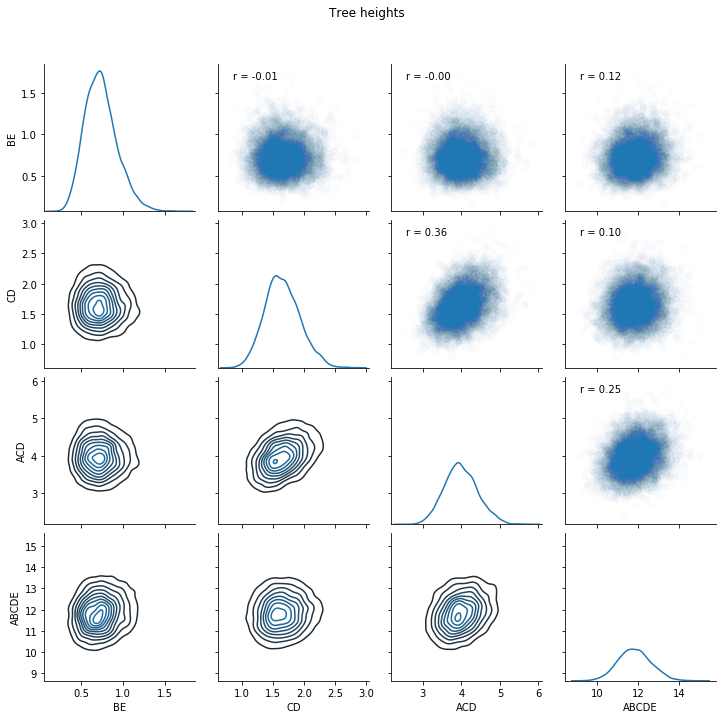

In [42]:
g = seaborn.PairGrid(beast_data[clade_names])

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = g.map_diag(seaborn.kdeplot)
g = g.map_upper(plt.scatter, alpha=0.01)
g = g.map_lower(seaborn.kdeplot)
g = g.map_upper(corrfunc)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Tree heights')

Text(0.5, 0.98, 'Unconstrained values')

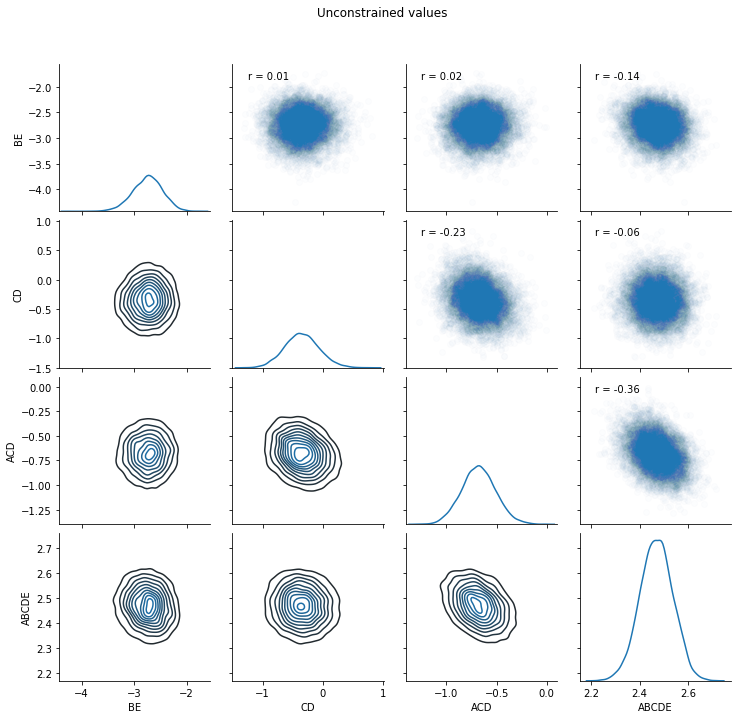

In [44]:
from scipy import stats

beast_values = tf.convert_to_tensor(beast_data[clade_names].values, dtype=tf.float32)
beast_values_trans = tree_chain.inverse(beast_values)
beast_data_trans = pd.DataFrame(beast_values_trans.numpy(), columns=clade_names)
g = seaborn.PairGrid(beast_data_trans)
g = g.map_upper(plt.scatter, alpha=0.01)
g = g.map_diag(seaborn.kdeplot)
g = g.map_lower(seaborn.kdeplot)
g.map_upper(corrfunc)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Unconstrained values')